
⬇️ Veri İndiriliyor: dry_bean...

BÖLÜM 1: SINIFLANDIRMA ANALİZİ (DRY BEAN DATASET)

--- VERİ SETİ TANITIMI ---
• Toplam Örnek Sayısı: 13611
• Özellik (Feature) Sayısı: 16
• Hedef Değişken: 'Class'

>> SINIF DAĞILIMI VE DENGE KONTROLÜ:
Class
DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: count, dtype: int64
>> DURUM: Veri seti DENGESİZ (Imbalanced). En büyük sınıf, en küçüğün 6.8 katı.


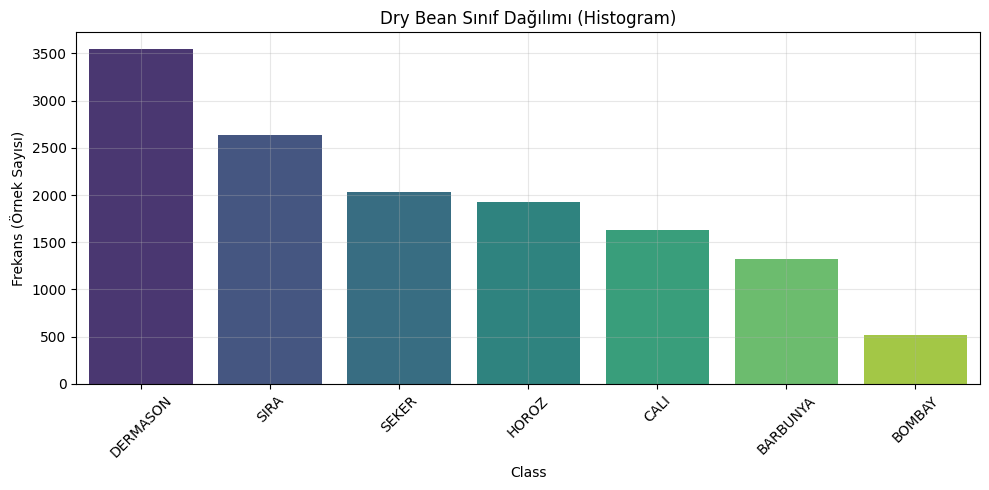


--- KULLANILAN MODELLER ---
1. SVM (Destek Vektör Makineleri): RBF Kernel kullanıldı.
2. XGBoost (Gradient Boosting): Ağaç tabanlı modern algoritma.

--------------------------------------------------------------------------------
MODEL PERFORMANS SONUÇLARI VE GÖRSELLEŞTİRMELER (3-FOLD CV)
--------------------------------------------------------------------------------

🔹 MODEL: SVM
   📊 Ortalama ACC (Doğruluk): %92.84
   📊 Ortalama F-Score (Weighted): %92.85


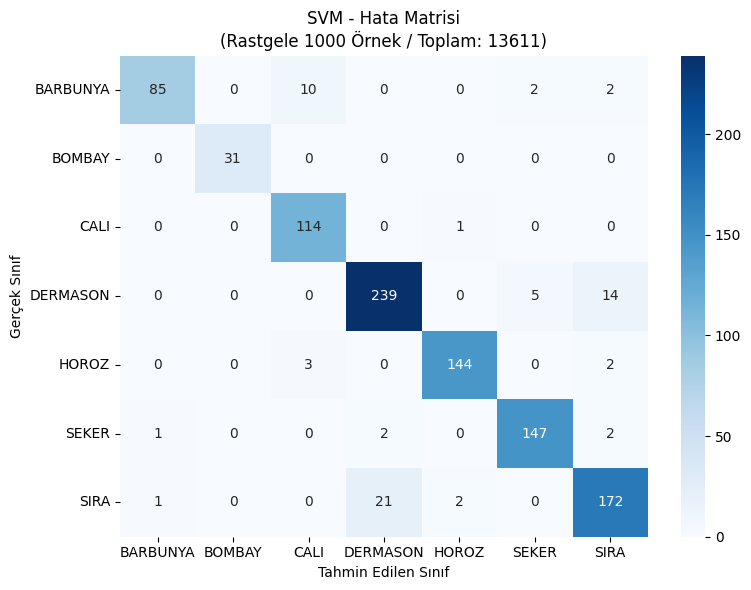


🔹 MODEL: XGBoost
   📊 Ortalama ACC (Doğruluk): %92.40
   📊 Ortalama F-Score (Weighted): %92.40


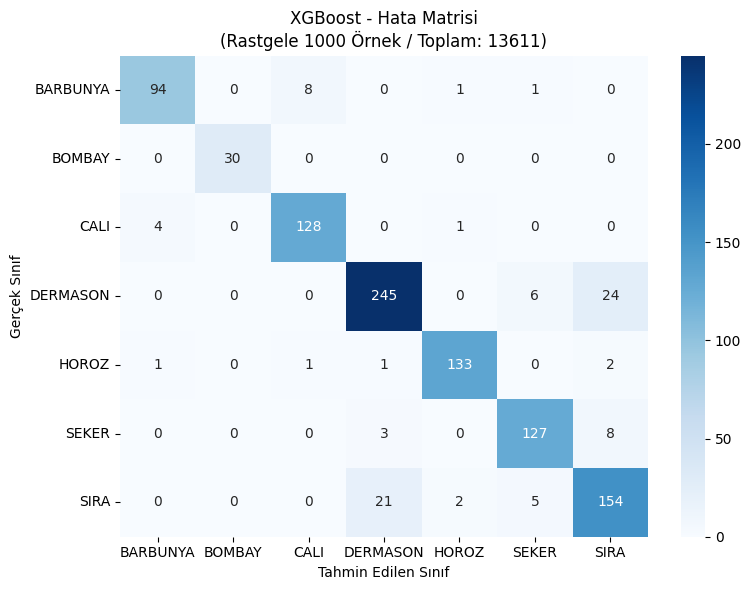


⬇️ Veri İndiriliyor: forest_fire...


BÖLÜM 2: REGRESYON ANALİZİ (ALGERIAN FOREST FIRES)

--- VERİ SETİ TANITIMI ---
• Temizlenmiş Örnek Sayısı: 243
• Hedef Değişken: 'FWI' (Fire Weather Index)

>> HEDEF DEĞİŞKEN İSTATİSTİKLERİ:
     count      mean       std  min  25%  50%    75%   max
FWI  243.0  7.035391  7.440568  0.0  0.7  4.2  11.45  31.1


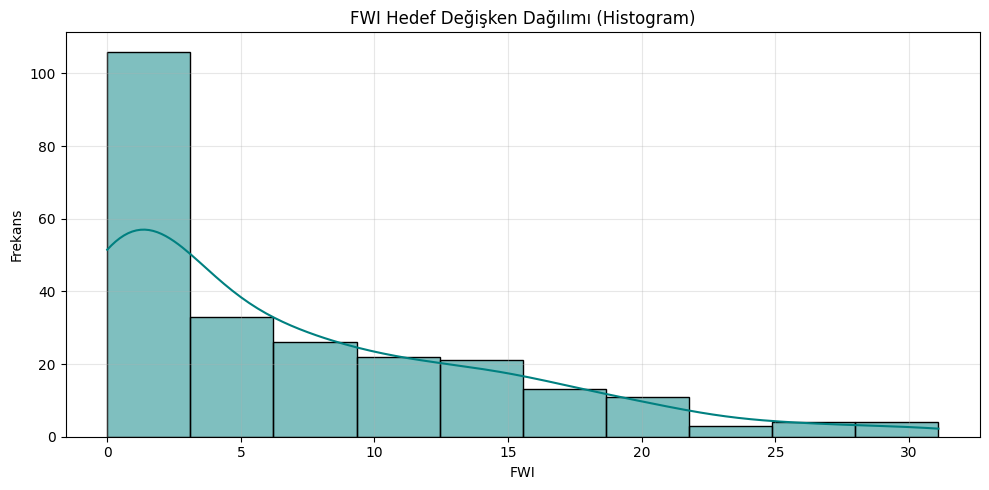


--- KULLANILAN MODELLER ---
1. SVR (Destek Vektör Regresyonu): RBF Kernel.
2. XGBoost Regressor: Gradyan artırma tabanlı regresyon.

--------------------------------------------------------------------------------
MODEL PERFORMANS SONUÇLARI VE GÖRSELLEŞTİRMELER (3-FOLD CV)
--------------------------------------------------------------------------------

🔹 MODEL: SVR
   📊 Ortalama MAE (Hata): 1.5800
   📊 Ortalama SMAPE (Yüzde Hata): %48.31


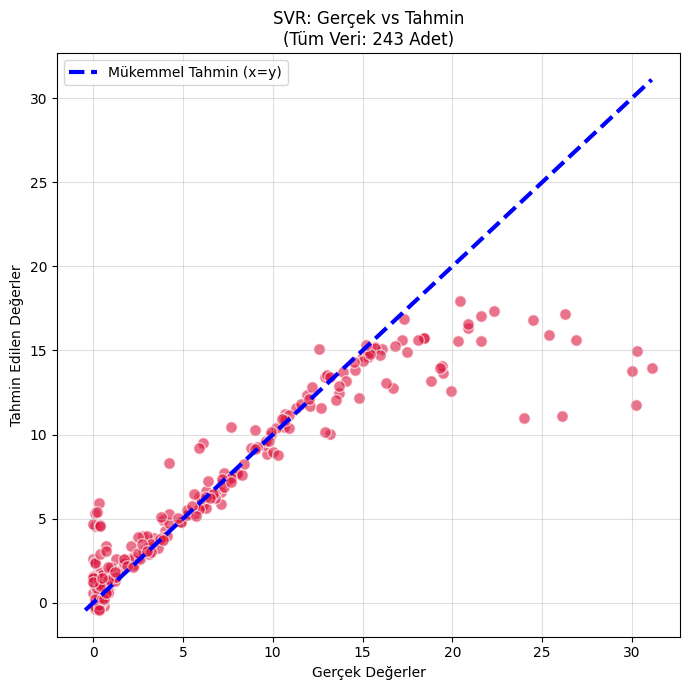


🔹 MODEL: XGBoost
   📊 Ortalama MAE (Hata): 0.7127
   📊 Ortalama SMAPE (Yüzde Hata): %23.82


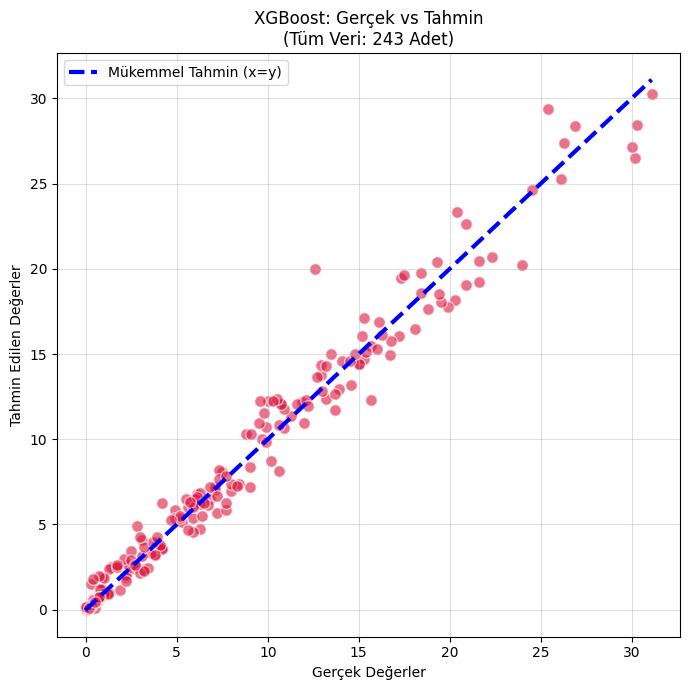




🏆 GENEL KARŞILAŞTIRMA TABLOSU
╒═════════════════════════════╤═════════╤══════════════╤════════════════╕
│ Veri Seti                   │ Model   │ 1. Metrik    │ 2. Metrik      │
╞═════════════════════════════╪═════════╪══════════════╪════════════════╡
│ Dry Bean (Sınıflandırma)    │ SVM     │ %92.84 (ACC) │ %92.85 (F1)    │
├─────────────────────────────┼─────────┼──────────────┼────────────────┤
│ Dry Bean (Sınıflandırma)    │ XGBoost │ %92.40 (ACC) │ %92.40 (F1)    │
├─────────────────────────────┼─────────┼──────────────┼────────────────┤
│ Algerian Forest (Regresyon) │ SVR     │ 1.5800 (MAE) │ %48.31 (SMAPE) │
├─────────────────────────────┼─────────┼──────────────┼────────────────┤
│ Algerian Forest (Regresyon) │ XGBoost │ 0.7127 (MAE) │ %23.82 (SMAPE) │
╘═════════════════════════════╧═════════╧══════════════╧════════════════╛


In [ ]:
# @title Proje Kodları: Kapsamlı Analiz ve Görselleştirme (Sunum İçin Hazır)
!pip install -q xgboost scikit-learn pandas matplotlib seaborn openpyxl tabulate

import os
import requests
import zipfile
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tabulate import tabulate

# Machine Learning
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_predict, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, confusion_matrix

warnings.filterwarnings('ignore')

# GLOBAL SONUÇ LİSTESİ
ALL_RESULTS = []

# --------------------------------------------------------------------------------
# YARDIMCI FONKSİYONLAR
# --------------------------------------------------------------------------------
def calculate_smape(y_true, y_pred):
    """Simetrik Ortalama Mutlak Yüzde Hata (SMAPE)"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    with np.errstate(divide='ignore', invalid='ignore'):
        smape = numerator / denominator
        smape[denominator == 0] = 0.0
    return np.mean(smape) * 100

def get_plot_samples(y_true, y_pred):
    """
    GÖRSELLEŞTİRME KURALI:
    Veri seti > 1000 ise rastgele 1000 örnek seçilerek çizim yapılır.
    """
    # Pandas yapısını numpy array'e çevir
    if isinstance(y_true, (pd.Series, pd.DataFrame)): y_true = y_true.values.ravel()
    if isinstance(y_pred, (pd.Series, pd.DataFrame)): y_pred = y_pred.values.ravel()

    total = len(y_true)
    if total > 1000:
        idx = np.random.choice(total, 1000, replace=False)
        return y_true[idx], y_pred[idx], f"(Rastgele 1000 Örnek / Toplam: {total})"
    return y_true, y_pred, f"(Tüm Veri: {total} Adet)"

def check_balance(df, target_col):
    """Sınıf dengesini kontrol eder."""
    counts = df[target_col].value_counts()
    ratio = counts.max() / counts.min()
    print(f"\n>> SINIF DAĞILIMI VE DENGE KONTROLÜ:")
    print(counts)
    if ratio > 1.5:
        print(f">> DURUM: Veri seti DENGESİZ (Imbalanced). En büyük sınıf, en küçüğün {ratio:.1f} katı.")
    else:
        print(f">> DURUM: Veri seti DENGELİ (Balanced).")

def plot_histogram(data, column, title, is_categorical=False):
    """Veri dağılımını gösteren histogram."""
    plt.figure(figsize=(10, 5))
    if is_categorical:
        sns.countplot(x=data[column], palette='viridis', order=data[column].value_counts().index)
        plt.xticks(rotation=45)
        plt.ylabel('Frekans (Örnek Sayısı)')
    else:
        sns.histplot(data[column], kde=True, color='teal')
        plt.ylabel('Frekans')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix_final(y_true, y_pred, title, class_names):
    """Hata Matrisi Çizer (Örneklem kuralına uyar)."""
    y_s, p_s, note = get_plot_samples(y_true, y_pred)
    cm = confusion_matrix(y_s, p_s)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{title} - Hata Matrisi\n{note}')
    plt.xlabel('Tahmin Edilen Sınıf')
    plt.ylabel('Gerçek Sınıf')
    plt.tight_layout()
    plt.show()

def plot_xy_final(y_true, y_pred, title):
    """Gerçek vs Tahmin (x=y) Grafiği Çizer (Örneklem kuralına uyar)."""
    y_s, p_s, note = get_plot_samples(y_true, y_pred)

    plt.figure(figsize=(7, 7))
    plt.scatter(y_s, p_s, alpha=0.6, color='crimson', edgecolors='white', s=70)

    # İdeal tahmin doğrusu
    m, M = min(y_s.min(), p_s.min()), max(y_s.max(), p_s.max())
    plt.plot([m, M], [m, M], 'b--', lw=3, label='Mükemmel Tahmin (x=y)')

    plt.title(f'{title}: Gerçek vs Tahmin\n{note}')
    plt.xlabel('Gerçek Değerler')
    plt.ylabel('Tahmin Edilen Değerler')
    plt.legend()
    plt.grid(True, alpha=0.4)
    plt.tight_layout()
    plt.show()

# --------------------------------------------------------------------------------
# VERİ YÖNETİMİ (DATA MANAGER)
# --------------------------------------------------------------------------------
class DataManager:
    def __init__(self):
        self.urls = {
            "dry_bean": "https://archive.ics.uci.edu/static/public/602/dry+bean+dataset.zip",
            "forest_fire": "https://archive.ics.uci.edu/static/public/547/algerian+forest+fires+dataset.zip"
        }
        self.files = {"dry_bean": "Dry_Bean_Dataset.xlsx", "forest_fire": "Algerian_forest_fires_dataset_UPDATE.csv"}

    def get_data(self, key):
        print(f"\n⬇️ Veri İndiriliyor: {key}...")
        try:
            r = requests.get(self.urls[key])
            with zipfile.ZipFile(io.BytesIO(r.content)) as z:
                t = [n for n in z.namelist() if self.files[key] in n and not n.startswith('__')][0]
                with z.open(t) as f:
                    return pd.read_excel(f) if key == "dry_bean" else pd.read_csv(f, header=1)
        except Exception: return None

# --------------------------------------------------------------------------------
# BÖLÜM 1: SINIFLANDIRMA ANALİZİ (DRY BEAN)
# --------------------------------------------------------------------------------
def run_classification():
    df = DataManager().get_data("dry_bean")
    if df is None: return

    print("\n" + "="*80)
    print("BÖLÜM 1: SINIFLANDIRMA ANALİZİ (DRY BEAN DATASET)")
    print("="*80)

    # 1. Veri Tanıtımı
    print("\n--- VERİ SETİ TANITIMI ---")
    print(f"• Toplam Örnek Sayısı: {len(df)}")
    print(f"• Özellik (Feature) Sayısı: {df.shape[1]-1}")
    print(f"• Hedef Değişken: 'Class'")

    # Denge Kontrolü
    check_balance(df, 'Class')

    # Histogram
    plot_histogram(df, 'Class', 'Dry Bean Sınıf Dağılımı (Histogram)', is_categorical=True)

    # 2. Hazırlık
    X = df.drop('Class', axis=1)
    le = LabelEncoder()
    y = le.fit_transform(df['Class'])
    X_scaled = StandardScaler().fit_transform(X)

    # 3. Modellerin Tanıtımı
    models = {
        "SVM": SVC(kernel='rbf', random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    }

    print("\n--- KULLANILAN MODELLER ---")
    print("1. SVM (Destek Vektör Makineleri): RBF Kernel kullanıldı.")
    print("2. XGBoost (Gradient Boosting): Ağaç tabanlı modern algoritma.")

    # 4. Performans ve Grafikler
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    print("\n" + "-"*80)
    print("MODEL PERFORMANS SONUÇLARI VE GÖRSELLEŞTİRMELER (3-FOLD CV)")
    print("-"*80)

    for name, model in models.items():
        print(f"\n🔹 MODEL: {name}")

        # Metrik Hesaplama
        scores = cross_validate(model, X_scaled, y, cv=cv, scoring={'acc': 'accuracy', 'f1': 'f1_weighted'})
        acc = scores['test_acc'].mean() * 100
        f1 = scores['test_f1'].mean() * 100

        print(f"   📊 Ortalama ACC (Doğruluk): %{acc:.2f}")
        print(f"   📊 Ortalama F-Score (Weighted): %{f1:.2f}")

        ALL_RESULTS.append({
            "Veri Seti": "Dry Bean (Sınıflandırma)",
            "Model": name,
            "1. Metrik": f"%{acc:.2f} (ACC)",
            "2. Metrik": f"%{f1:.2f} (F1)"
        })

        # Grafik Çizimi
        y_pred = cross_val_predict(model, X_scaled, y, cv=cv)
        plot_confusion_matrix_final(y, y_pred, name, le.classes_)

# --------------------------------------------------------------------------------
# BÖLÜM 2: REGRESYON ANALİZİ (ALGERIAN FOREST)
# --------------------------------------------------------------------------------
def run_regression():
    df = DataManager().get_data("forest_fire")
    if df is None: return

    print("\n\n" + "="*80)
    print("BÖLÜM 2: REGRESYON ANALİZİ (ALGERIAN FOREST FIRES)")
    print("="*80)

    # Veri Temizliği
    df.columns = [c.strip() for c in df.columns]
    df = df[pd.to_numeric(df['day'], errors='coerce').notnull()] # Metadata satırlarını temizle
    df = df.drop(columns=[c for c in ['day', 'month', 'year', 'Classes'] if c in df.columns])
    df = df.apply(pd.to_numeric, errors='coerce').dropna() # Hatalı verileri temizle

    # 1. Veri Tanıtımı
    print("\n--- VERİ SETİ TANITIMI ---")
    print(f"• Temizlenmiş Örnek Sayısı: {len(df)}")
    print(f"• Hedef Değişken: 'FWI' (Fire Weather Index)")

    print("\n>> HEDEF DEĞİŞKEN İSTATİSTİKLERİ:")
    print(df['FWI'].describe().to_frame().T)

    # Histogram
    plot_histogram(df, 'FWI', 'FWI Hedef Değişken Dağılımı (Histogram)')

    # 2. Hazırlık
    X = df.drop('FWI', axis=1)
    y = df['FWI']
    X_scaled = StandardScaler().fit_transform(X)

    # 3. Modellerin Tanıtımı
    models = {
        "SVR": SVR(kernel='rbf'),
        "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42)
    }

    print("\n--- KULLANILAN MODELLER ---")
    print("1. SVR (Destek Vektör Regresyonu): RBF Kernel.")
    print("2. XGBoost Regressor: Gradyan artırma tabanlı regresyon.")

    # 4. Performans ve Grafikler
    cv = KFold(n_splits=3, shuffle=True, random_state=42)

    print("\n" + "-"*80)
    print("MODEL PERFORMANS SONUÇLARI VE GÖRSELLEŞTİRMELER (3-FOLD CV)")
    print("-"*80)

    for name, model in models.items():
        print(f"\n🔹 MODEL: {name}")

        mae_scores, smape_scores = [], []

        for tr, ts in cv.split(X_scaled):
            model.fit(X_scaled[tr], y.iloc[tr])
            pred = model.predict(X_scaled[ts])
            mae_scores.append(mean_absolute_error(y.iloc[ts], pred))
            smape_scores.append(calculate_smape(y.iloc[ts], pred))

        mae = np.mean(mae_scores)
        smape = np.mean(smape_scores)

        print(f"   📊 Ortalama MAE (Hata): {mae:.4f}")
        print(f"   📊 Ortalama SMAPE (Yüzde Hata): %{smape:.2f}")

        ALL_RESULTS.append({
            "Veri Seti": "Algerian Forest (Regresyon)",
            "Model": name,
            "1. Metrik": f"{mae:.4f} (MAE)",
            "2. Metrik": f"%{smape:.2f} (SMAPE)"
        })

        # Grafik Çizimi
        y_pred = cross_val_predict(model, X_scaled, y, cv=cv)
        plot_xy_final(y, y_pred, name)

# --------------------------------------------------------------------------------
# ANA ÇALIŞTIRMA VE KARŞILAŞTIRMA TABLOSU
# --------------------------------------------------------------------------------
if __name__ == "__main__":
    run_classification()
    run_regression()

    print("\n\n")
    print("="*80)
    print("🏆 GENEL KARŞILAŞTIRMA TABLOSU")
    print("="*80)

    df_results = pd.DataFrame(ALL_RESULTS)
    print(tabulate(df_results, headers="keys", tablefmt="fancy_grid", showindex=False))